
## Load HRET ssh, compute basic statistics about ssh and currents


In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import numpy as np
import xarray as xr
from utide._ut_constants import ut_constants as utide

from utils import *

# useful variables
j=np.complex(0,1)
cpd=2.*np.pi/86400. # from cpd to radian/s
crs = ccrs.PlateCarree() # cartopy

#datadir = '/home2/pharos/othr/aponte/tides/HRET/'
datadir = './'

In [2]:
# load hret for one constituent
hret = xr.open_dataset(datadir+'Carrere_HRET_testing.nc',chunks={'longitude': 500, 'latitude': 500})
#hret = hret.sel(longitude=slice(140.,270.),latitude=slice(-40.,40.))
print(hret)

<xarray.Dataset>
Dimensions:    (latitude: 2640, longitude: 7200)
Coordinates:
  * longitude  (longitude) float64 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 ...
  * latitude   (latitude) float64 -66.0 -65.95 -65.9 -65.85 -65.8 -65.75 ...
Data variables:
    M2re       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    M2im       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    K1re       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    K1im       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    S2re       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    S2im       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    O1re       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    O1im       (latitude, longitude) float64 dask.array<shape=(

In [3]:
# consituents
constituents = ['M2','N2','S2','K1','O1','P1']

omega = dict()
for cst,o in zip(utide['const']['name'], utide['const']['freq']):
    if cst in constituents:
        omega[cst] = o*24. # cpd, input frequencies are cph
        print(cst+' omega=%e rad/s, %.3f cpd'%(o*2.*np.pi/3600., o*24.))

O1 omega=6.759774e-05 rad/s, 0.930 cpd
P1 omega=7.252295e-05 rad/s, 0.997 cpd
K1 omega=7.292116e-05 rad/s, 1.003 cpd
N2 omega=1.378797e-04 rad/s, 1.896 cpd
M2 omega=1.405189e-04 rad/s, 1.932 cpd
S2 omega=1.454441e-04 rad/s, 2.000 cpd


In [4]:
# load bathymetry and a minimum water for analysis
h = load_bathy(lon=hret.longitude, lat=hret.latitude)
hc=1000. # locations with depth lower than hc are not considered in statistics

---

# ssh maps and statistics


/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


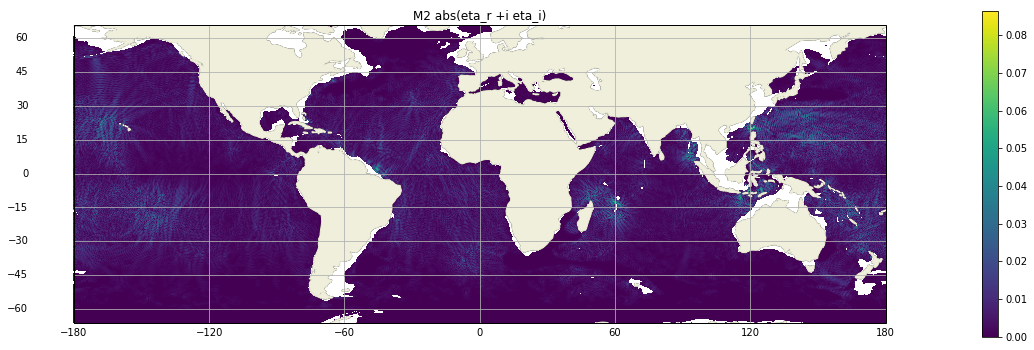

In [5]:
cst='M2'

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111, projection=crs)
#
toplt = np.abs(hret[cst+'re']+j*hret[cst+'im'])
toplt = toplt.where(h>hc)
toplt.plot()
ax.set_title(cst+' abs(eta_r +i eta_i)')
gl = ax.gridlines(crs=crs, draw_labels=True) 
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
plt.show()


/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


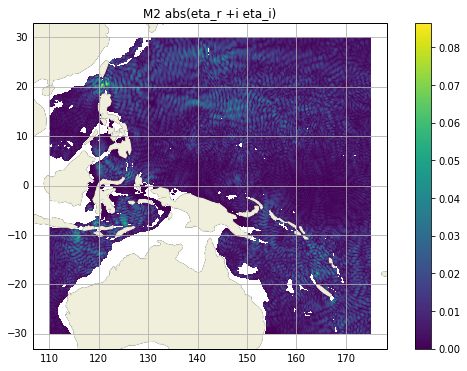

In [6]:
# zoom 
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=crs)
#
toplt = np.abs(hret[cst+'re']+j*hret[cst+'im'])
toplt = toplt.sel(longitude=slice(110.,175.),latitude=slice(-30.,30.))
toplt = toplt.where(h>hc)
toplt.plot()
ax.set_title(cst+' abs(eta_r +i eta_i)')
gl = ax.gridlines(crs=crs, draw_labels=True) 
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
plt.show()

In [7]:
# plot longitudinal mean of amplitudes
Am = dict()
A90 = dict()
Astd = dict()
for cst in constituents:
    Aeta = np.abs(hret[cst+'re']+j*hret[cst+'im'])
    Aeta = Aeta.where(h>hc)
    Am[cst] = Aeta.mean('longitude')
    A90[cst] = Aeta.quantile(.9,dim='longitude')
    Astd[cst] = Aeta.std('longitude')    

/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


Text(0.5,0,'[cm]')

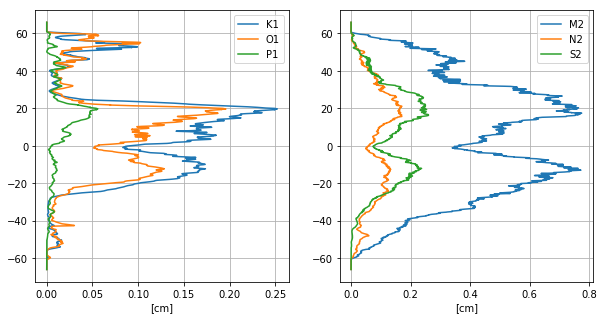

In [8]:
fig=plt.figure(figsize=(10,5))

lat=Am['M2']['latitude'].values

# diurnal constituents
ax = fig.add_subplot(121)
for cst in constituents:
    if omega[cst]<1.5:
        ax.plot(Am[cst]*1.e2,lat,label=cst)
ax.grid()
ax.legend()
ax.set_xlabel('[cm]')

# semidiurnal constituents
ax = fig.add_subplot(122)
for cst in constituents:
    if omega[cst]>1.5:
        ax.plot(Am[cst]*1.e2,lat,label=cst)
ax.grid()
ax.legend()
ax.set_xlabel('[cm]')


---

# Velocities

\begin{aligned}
\partial_t u - fv &= -g\partial_x \eta - r u, \\
\partial_t v + fu &= -g\partial_y \eta - r v,
\end{aligned}
where $r$ is a damping factor.

Assuming $u=\Re ( u_c e^{-i\omega t})$ where $u_c = u_r + i u_i$

\begin{aligned}
-i\omega u_c - f v_c &= -g\partial_x \eta_c - r u_c, \\
-i\omega v_c + f u_c &= -g\partial_y \eta_c - r v_c.
\end{aligned}
Or equivalently:
\begin{aligned}
-i(\omega+ir) u_c - f v_c &= -g\partial_x \eta_c, \\
-i(\omega+ir) v_c + f u_c &= -g\partial_y \eta_c.
\end{aligned}



(Need to check signs)

Which leads to:

\begin{aligned}
u_c = -g \frac{i\tilde\omega\partial_x \eta_c -f \partial_y \eta_c}{\tilde\omega^2 - f^2}, \\
v_c = -g \frac{f\partial_x \eta_c + i \tilde\omega \partial_y \eta_c}{\tilde\omega^2 - f^2},
\end{aligned}
where $\tilde\omega=\omega+ir$.



---

## Look first at M2


In [9]:
# compute Coriolis frequency
f = 2*omega['K1']*cpd*np.sin(np.pi/180.*hret['latitude'])

#
cst = 'M2'
detadx_c, detady_c = grad(ri2c(hret[cst+'re'],hret[cst+'im']))
u_c, v_c = mom_inv(detadx_c, detady_c, f, omega[cst]*cpd)
print(u_c)

<xarray.DataArray (latitude: 2639, longitude: 7200)>
dask.array<shape=(2639, 7200), dtype=complex128, chunksize=(499, 499)>
Coordinates:
  * latitude   (latitude) float64 -66.0 -65.95 -65.9 -65.85 -65.8 -65.75 ...
  * longitude  (longitude) float64 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 ...


/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:25: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  elif np.issubdtype(dtype, int):
/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:29: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif np.issubdtype(dtype, complex):


/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


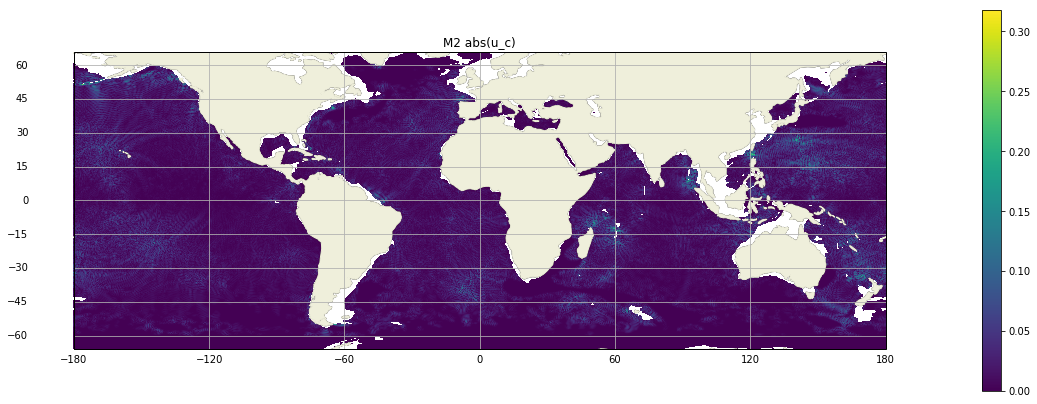

In [10]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111, projection=crs)
#
toplt = np.abs(u_c)
#toplt = toplt.where(toplt<1.) # mask values larger than 1 m/s
toplt = toplt.where(h>hc)
toplt.plot()
ax.set_title(cst+' abs(u_c)')
gl=ax.gridlines(crs=crs, draw_labels=True) 
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
plt.show()


/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


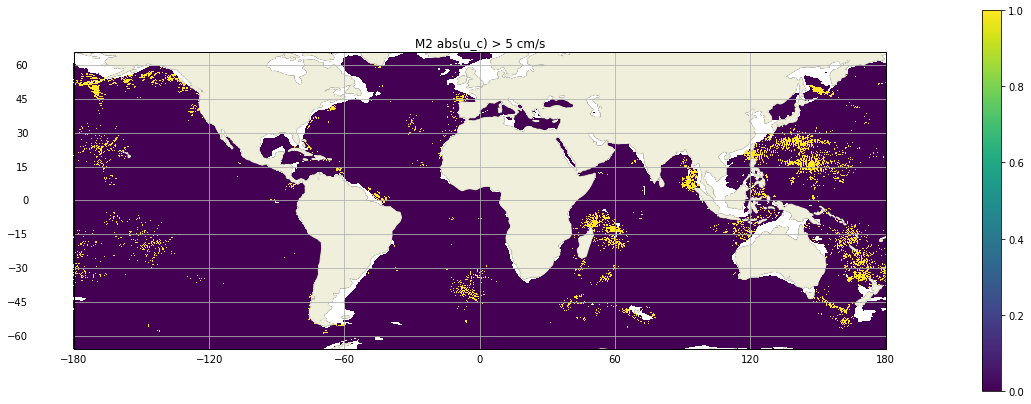

In [11]:
# map values above >10cm/s
toplt = np.abs(u_c)
threshold=.05
toplt = toplt.where(toplt<threshold, other=1.)
toplt = toplt.where(toplt>=threshold, other=0.)
toplt = toplt.where(h>hc)

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111, projection=crs)
#
toplt.plot(vmin=0.,vmax=1.)
ax.set_title(cst+' abs(u_c) > %d cm/s'%(threshold*1.e2))
gl=ax.gridlines(crs=crs, draw_labels=True) 
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
plt.show()

/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


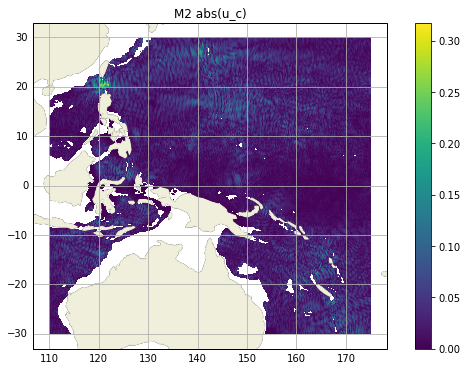

In [12]:
# zoom
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=crs)
#
toplt = np.abs(u_c)
#toplt = toplt.where(np.abs(toplt)<1.) # mask values larger than 1 m/s
toplt = toplt.where(h>hc)
toplt = toplt.sel(longitude=slice(110.,175.),latitude=slice(-30.,30.))
toplt.plot()
ax.set_title(cst+' abs(u_c)')
gl=ax.gridlines(crs=crs, draw_labels=True) 
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
plt.show()

---

## compute velocities for all constituents

In [13]:
# plot longitudinal mean of amplitudes and 90% quantile
Um = dict(); Vm = dict()
U90 = dict(); V90 = dict()
for cst in constituents:
    eta = ri2c(hret[cst+'re'], hret[cst+'im'])
    eta = eta.where(h>hc)
    detadx_c, detady_c = grad(eta)
    u_c, v_c = mom_inv(detadx_c, detady_c, f, omega[cst]*cpd)
    Um[cst] = np.abs(u_c).mean('longitude')
    Vm[cst] = np.abs(v_c).mean('longitude')
    U90[cst] = np.abs(u_c).quantile(.9,dim='longitude')
    V90[cst] = np.abs(v_c).quantile(.9,dim='longitude')    

/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:25: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  elif np.issubdtype(dtype, int):
/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:29: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif np.issubdtype(dtype, complex):
/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/nu

Text(0.5,1,'mean zonal current amplitude')

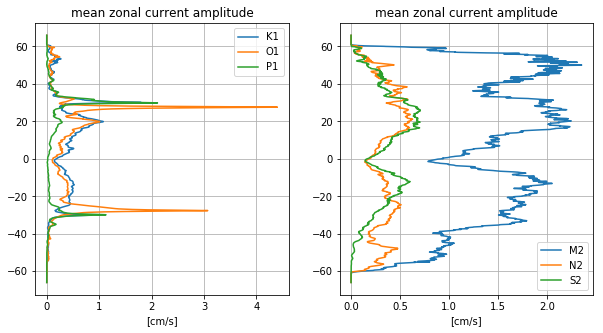

In [14]:
# plot average 
fig=plt.figure(figsize=(10,5))

lat=Um['M2']['latitude'].values

# diurnal constituents
ax = fig.add_subplot(121)
for cst in constituents:
    if omega[cst]<1.5:
        toplt = Um[cst]
        #toplt = toplt.where(np.abs((omega[cst]*cpd-f)/f)>.1)
        #toplt = toplt.where(np.abs((omega[cst]*cpd+f)/f)>.1)
        ax.plot(toplt*1.e2,lat,label=cst)
ax.grid()
ax.legend()
ax.set_xlabel('[cm/s]')
ax.set_title('mean zonal current amplitude')

# semidiurnal constituents
ax = fig.add_subplot(122)
for cst in constituents:
    if omega[cst]>1.5:
        ax.plot(Um[cst]*1.e2,lat,label=cst)
ax.grid()
ax.legend()
ax.set_xlabel('[cm/s]')
ax.set_title('mean zonal current amplitude')

Text(0.5,1,'90% quantile zonal current amplitude')

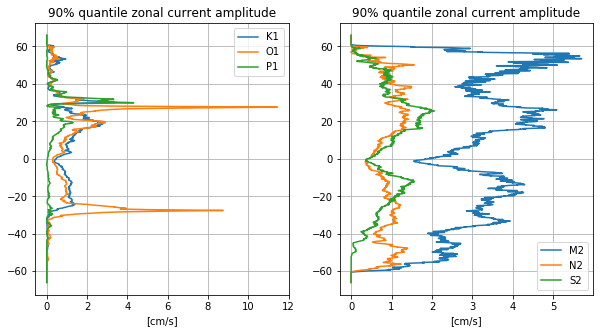

In [15]:
# plot 90% quantile

fig=plt.figure(figsize=(10,5))

lat=U90['M2']['latitude'].values

# diurnal constituents
ax = fig.add_subplot(121)
for cst in constituents:
    if omega[cst]<1.5:
        toplt = U90[cst]
        #toplt = toplt.where(np.abs((omega[cst]*cpd-f)/f)>.1)
        #toplt = toplt.where(np.abs((omega[cst]*cpd+f)/f)>.1)
        ax.plot(toplt*1.e2,lat,label=cst)
ax.grid()
ax.legend()
ax.set_xlabel('[cm/s]')
ax.set_title('90% quantile zonal current amplitude')

# semidiurnal constituents
ax = fig.add_subplot(122)
for cst in constituents:
    if omega[cst]>1.5:
        ax.plot(U90[cst]*1.e2,lat,label=cst)
ax.grid()
ax.legend()
ax.set_xlabel('[cm/s]')
ax.set_title('90% quantile zonal current amplitude')



---

## Inspect the effect of damping factor on M2 and K1

In [16]:
# plot longitudinal mean of amplitudes and 90% quantile
Urm = dict(); Vrm = dict()
Tr = [2.e-1, 2.e0, 2.e1]
for cst in ['M2','K1']:
    Urm[cst] = dict()
    Vrm[cst] = dict()
    for tr in Tr:
        eta = ri2c(hret[cst+'re'], hret[cst+'im'])
        eta = eta.where(h>hc)
        detadx_c, detady_c = grad(eta)
        u_c, v_c = mom_inv(detadx_c, detady_c, f, omega[cst]*cpd, r=1./tr/86400.)
        Urm[cst][tr] = np.abs(u_c).mean('longitude')
        Vrm[cst][tr] = np.abs(v_c).mean('longitude')

/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:25: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  elif np.issubdtype(dtype, int):
/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:29: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif np.issubdtype(dtype, complex):


Text(0.5,1,'mean zonal current amplitude')

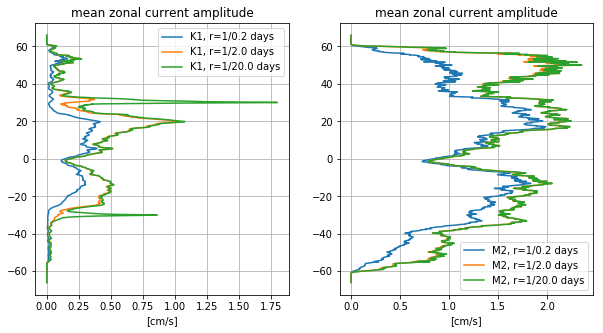

In [17]:
# plot average 
fig=plt.figure(figsize=(10,5))

lat=Um['M2']['latitude'].values

# diurnal constituents
ax = fig.add_subplot(121)
cst='K1'
for tr in Tr:
    toplt = Urm[cst][tr]
    #toplt = toplt.where(np.abs((omega[cst]*cpd-f)/f)>.1)
    #toplt = toplt.where(np.abs((omega[cst]*cpd+f)/f)>.1)
    ax.plot(toplt*1.e2,lat,label=cst+', r=1/%.1f days'%tr)
ax.grid()
ax.legend()
ax.set_xlabel('[cm/s]')
ax.set_title('mean zonal current amplitude')

# semidiurnal constituents
ax = fig.add_subplot(122)
cst = 'M2'
for tr in Tr:    
    ax.plot(Urm[cst][tr]*1.e2,lat,label=cst+', r=1/%.1f days'%tr)
ax.grid()
ax.legend()
ax.set_xlabel('[cm/s]')
ax.set_title('mean zonal current amplitude')